## Importation de librairies

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #GPU si on est au gmm sinon cpu = lent
print(device)

cuda


## Téléchargement du dataset FashionMNIST

The ten categories in Fashion MNIST are:
1.T-shirt/top
2.Trouser
3.Pullover
4.Dress
5.Coat
6.Sandal
7.Shirt
8.Sneaker
9.Bag
10.Ankle boot

In [3]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Def : (que j'avais pas compris)

Un batch, c’est un groupe d’images traitées en même temps.  
Exemple : batch size = 32, le réseau voit 32 images en parallèle.

kernel (ou filtre) =/ de batch : c'est un petit détecteur de motifs.  
il glisse sur l’image, il regarde une petite zone locale, il produit une activation

Canal :  
Chaque canal représente un motif différent, appris par un filtre différent.  
Attention, un canal peut avoir des valeurs grandes et un autre très petites.

Tenseur :  
un tableau de normes 3D, 4D etc  
ici image MNIST : [1, 28, 28],  
batch de 64 images : [64, 1, 28, 28]  
=> Tenseur en 4D

Activation :  
valeur produite après une couche (conv, linéaire etc)  
entrée-> convolution -> activation  
Chaque pixel de sortie de conv est une activation

Rappel :  
L’encodeur prend une image + son label  
il les compresse en une représentation latente probabiliste, conditionnée par la classe

---

### Explications :

_init_ :  
definit l'architecture de l'encodeur et du décodeur  
(Latent_dim = taille du vecteur latent z, num_classes= nombre de classes ex robe, t-shirt mais c'est des chiffres)

---

### Partie Encodeur :

self.encodeur :  
recoit l'image + notre condition (label) qui sont concaténés en canaux  

(Le label est transformé en cartes spatiales constantes :  
chaque pixel “sait” à quelle classe appartient l’image  
donc pour l’encodeur, le label est juste une information supplémentaire par pixel.)

Puis 3 convolutions réduisant la taille (réduire les détails inutiles)  
et en augmentant les canaux (on augmente la richesse de l'information)  
grace à torch.nn via la focntion Conv2d.

Pour chaque Convolution, les filtres voient image + classe  
et apprennent les motifs importants pour la classe.

Donc 1 + num_classes c'est les canaux du début de l'encodeur,  
32 le nombre de canaux que l'on veut à la fin de la première couche  
etc jusqu'à 128.

---

#### remarques : comment ca marche vraiment ?

nn.Sequential est un conteneur de couches :  
Conv2d -> BatchNorm2d -> ReLU  
en cycle pour chaque couche du réseau

D'abord on fait la convolution avec Conv2d  
(couche de convolution 2D):  
repére des motifs visuels (bords, courbes, formes)  
et produire des cartes de caractéristiques (features).

On lui donnes le batch_size, le nombre de canaux  
et la hauteur/largeur des images  
==> Tenseur de 4D.

Attention : choix de modélisation

Le kernel, c’est la fenêtre de vision du filtre,  
kernel = 4 → le filtre regarde un bloc 4×4.

Le stride dit de combien de pixels le filtre avance à chaque pas.  
stride = 1 → pixel par pixel  
stride = 2 → un pixel sur deux

Le padding ajoute une bordure de zéros autour de l’image.  
Sans padding les bords sont moins vus et l’image rétrécit trop vite.  
Avec padding = 1, les filtres peuvent encore “voir” les bords  
et la réduction est contrôlée.

Attention :  
Pourquoi je ne donne pas la taille de l’image à Conv2d ?  
car une convolution est locale et indépendante de la taille globale de l’image  
vu que le kernel regarde une petite zone locale,  
il se déplace automatiquement sur toute l’image,  
peu importe que l’image fasse 28×28 ou 256×256.

---

pour chaque convolution (couches),  
on utilise BatchNorm2d stabiliser et accélérer le train  
(sinon les gradients sont instables par ex).

La fonction travaille canal par canal (pas par pixel)  
ou il regarde tous les pixels,  
de toutes les images du batch,  
mais pour chaque canal indépendament.

Il force les activations à rester dans une plage “raisonnable”  
en centrant les valeurs autour de 0  
(les recentre (moyenne ≈ 0) et les redimensionne (variance ≈ 1) pour VAE).

=> BatchNorm normalise chaque canal séparément.

Il apprend :  
γ (gamma) : échelle  
β (beta) : décalage  

Formule finale :  
y=γx+β

Une activation instable est une valeur num qui pose problème  
pendant l'entrainement

Ex :  
activation trop grande comme  
[ 0.5, 1.2, 3.8, 57.3, 1200.7 ]  
=> gradients énormes, poids qui explosent, perte = NaN  
=> entraînement impossible

activation trop petite comme  
[ 0.00001, 0.00002, 0.00000 ]  
=> gradients ≈ 0, le réseau n’apprend plus  
=> apprentissage bloqué

---

ReLU(Rectified Linear Unit)  
permet la non-linéarité  
donc permets d'apprendre des formes complexes :

ReLU(x) = max(0, x)

En gros agit comme un intérrupteur  
signal utile → passe  
signal inutile → coupé

Finalement,  
BatchNorm centre valeurs autour de 0  
(les recentre (moyenne ≈ 0) et les redimensionne (variance ≈ 1) pour VAE)  
et ReLU supprime les valeurs négatives  
=> le réseau apprend quand activer ou non un neurone

---

### PARTIE ESPACE LATENT : (Sampling)

Attention, un VAE ne sort pas une image,  
il sort une distribution latente q(z∣x,c)  
définie par une moyenne mue et une variance qui sont des vecteurs.

Mais après la partie décodeur,  
on nous donne à la fin [Batch, 128, 4, 4]  
donc chiant aussi  
on va transformer transforme la “petite image de features”  
en un vecteur latent avec X.view.

Ensuite on fait nn.linear  
ou chaque sortie dépend de toutes les entrées,  
contrairement à une convolution (locale),  
on change de type de couche  
(on enlève la dimension spatiale, on veut des vecteurs globaux).

Ici on veut passer de la taille du vecteur après l'encodeur  
128*4*4  
à la taille de la dim latente (dimension fixée).

On fait bien deux nn.linear  
car on veut récupérer le vecteur des mu et des logvar.

Attention :  
c'est bien logvar et pas variance directement  
car la variance doit être positive  
et que on ne sait pas quel nombre peut sortir du réseau  
(on fait plustard exp(logvar) via la fonction sample).

Attention :  
c_mu et fc_logvar sont identiques au départ,  
leur rôle est défini par leur utilisation dans le sampling  
et la KL divergence dans la loss (voir focntion loss_function)  
donc c'est le réseau apprend à leur donner un sens.

---

### Partie Decodage :


## 1. Definition de la classe CVAE


In [ ]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10): 
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # --- ENCODER ---

        # Le premier Conv2d prend 1 + 10 = 11 canaux (1 canal pour l'image N&B + 10 canaux pour les labels one-hot étirés)
        # a chaque étape de l'encodeur on divise la taille de l'image et augmente la taille des caractéristiques 
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14) #stride=2 divise la taille de l'image en 2
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Transition entre le monde des convolutions et l'espace latent
        # On applatit le volume de sorties de l'encodeur (qui est en 3D)
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) #Prédit la moyenne (μ) de la distribution pour chaque dimension de l'espace latent.
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) #Prédit le logarithme de la variance (log(σ2)) pour chaque dimension.




        # --- DECODER ---
        #  L'entrée du décodeur prend Latent + Label
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )


    # Fusion image + Label et encodage
    def encode(self, x, c): 
        # x: [Batch, 1, 28, 28] (image)
        # c: [Batch, 10] (One-hot labels)
        
        # Astuce : On étire le vecteur label pour qu'il fasse la taille de l'image (28x28)
        # c devient [Batch, 10, 28, 28]
        c_expanded = c.view(-1, self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        
        # On concatène sur la dimension des canaux (dim=1)
        # inputs devient [Batch, 11, 28, 28]
        inputs = torch.cat([x, c_expanded], 1)
        
        x = self.encoder(inputs)
        x = x.view(-1, 128 * 4 * 4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    # Tirage aléatoire de z dans l'espace latent
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    #Reconstruction
    def decode(self, z, c):
        # z: [Batch, latent_dim]
        # c: [Batch, num_classes]
        
        #ce sont deux vecteurs, on les colle
        inputs = torch.cat([z, c], 1) 
        
        x = self.fc_decode(inputs)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    #Flux principal pour enchainer les différents actions
    def forward(self, x, labels):
        
        # 1. Création du One-Hot Vector pour les labels
        c = torch.zeros(x.size(0), self.num_classes).to(x.device)
        c.scatter_(1, labels.view(-1, 1), 1)
        
        # 2. Encodage (Image + Condition)
        mu, logvar = self.encode(x, c)
        
        # 3. Sampling
        z = self.sample(mu, logvar)
        
        # 4. Décodage (Latent + Condition)
        recon_x = self.decode(z, c)
        
        return recon_x, mu, logvar

In [5]:
#fonction de perte
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD,BCE, KLD


# Le paramètre beta permet de pondérer l'importance de la KLD par rapport à la reconstruction (BCE)
# Un beta élevé favorise un espace latent bien structuré (utile pour la génération).
# Un beta faible favorise une reconstruction très fidèle (utile pour la précision des détails).

#### Point théorique : Adam optimizer
Adam (Adaptive Moment Estimation) est un algorithme d'optimisation utilisé pour l'entraînement des réseaux de neurones. 

Il est actuellement l'un des plus populaires car il combine les avantages de deux autres extensions de la descente de gradient : Momentum et RMSProp.

L'idée de Adam est de calculer un taux d'apprentissage adaptatif pour chaque paramètre du réseau. Au lieu d'utiliser un pas de mise à jour unique pour tous les poids, Adam ajuste la vitesse de modification de chaque poids en fonction de l'historique de ses gradients.

Il s'appuie sur deux statistiques calculées à chaque étape t :

- Le premier moment (mt​) : C'est la moyenne mobile des gradients (similaire au Momentum). Cela permet de garder une direction cohérente et d'éviter les oscillations brutales.

- Le second moment (vt​) : C'est la moyenne mobile du carré des gradients (similaire à RMSProp). Cela permet de normaliser les mises à jour en fonction de la variance des gradients.

## 2. Entrainement du CVAE

In [6]:
# Hyperparameters arbitraires
batch_size = 128
latent_dim = 10
learning_rate = 1e-3
epochs = 30
beta = 1


# Initialisation du CVAE model et du Adam optimizer
cvae =ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device) # c'est ici qu'on instance la dim latente
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Fonction pour entrainer le CVAE
def train_cvae_model(model, train_loader, optimizer, epochs, beta, device):
    history = {'loss': [], 'bce': [], 'kld': []}
    
    print(f"Début de l'entraînement : {epochs} epochs, Beta={beta}")
    print("-" * 50)

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        epoch_bce = 0
        epoch_kld = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, labels)
            
            # Calcul de la perte via la fonction définie précédemment
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_bce += bce.item()
            epoch_kld += kld.item()

        # Normalisation par le nombre total d'images
        num_samples = len(train_loader.dataset)
        avg_loss = epoch_loss / num_samples
        avg_bce = epoch_bce / num_samples
        avg_kld = epoch_kld / num_samples

        # Enregistrement dans l'historique
        history['loss'].append(avg_loss)
        history['bce'].append(avg_bce)
        history['kld'].append(avg_kld)

        # Affichage de la progression
        print(f"Epoch [{epoch}/{epochs}] | Loss: {avg_loss:.2f} | BCE: {avg_bce:.2f} | KLD: {avg_kld:.2f}")

    print("-" * 50)
    print("Entraînement terminé.")
    return history



# Lancement de l'entraînement
train1 = train_cvae_model(
    model=cvae, 
    train_loader=train_loader, 
    optimizer=optimizer, 
    epochs=30, 
    beta=1, 
    device=device
)

Début de l'entraînement : 30 epochs, Beta=1
--------------------------------------------------
Epoch [1/30] | Loss: 267.47 | BCE: 255.72 | KLD: 11.75
Epoch [2/30] | Loss: 244.09 | BCE: 231.98 | KLD: 12.11
Epoch [3/30] | Loss: 241.15 | BCE: 229.02 | KLD: 12.13
Epoch [4/30] | Loss: 239.44 | BCE: 227.33 | KLD: 12.10
Epoch [5/30] | Loss: 238.54 | BCE: 226.46 | KLD: 12.08
Epoch [6/30] | Loss: 237.70 | BCE: 225.57 | KLD: 12.13
Epoch [7/30] | Loss: 237.16 | BCE: 225.00 | KLD: 12.15
Epoch [8/30] | Loss: 236.58 | BCE: 224.41 | KLD: 12.17
Epoch [9/30] | Loss: 236.27 | BCE: 224.06 | KLD: 12.21
Epoch [10/30] | Loss: 235.95 | BCE: 223.72 | KLD: 12.23
Epoch [11/30] | Loss: 235.59 | BCE: 223.34 | KLD: 12.25
Epoch [12/30] | Loss: 235.37 | BCE: 223.11 | KLD: 12.26
Epoch [13/30] | Loss: 235.12 | BCE: 222.84 | KLD: 12.29
Epoch [14/30] | Loss: 234.94 | BCE: 222.63 | KLD: 12.32
Epoch [15/30] | Loss: 234.74 | BCE: 222.42 | KLD: 12.32
Epoch [16/30] | Loss: 234.61 | BCE: 222.27 | KLD: 12.34
Epoch [17/30] | Lo

## Visualisation des résultats

#### A. Visulation des images décodées

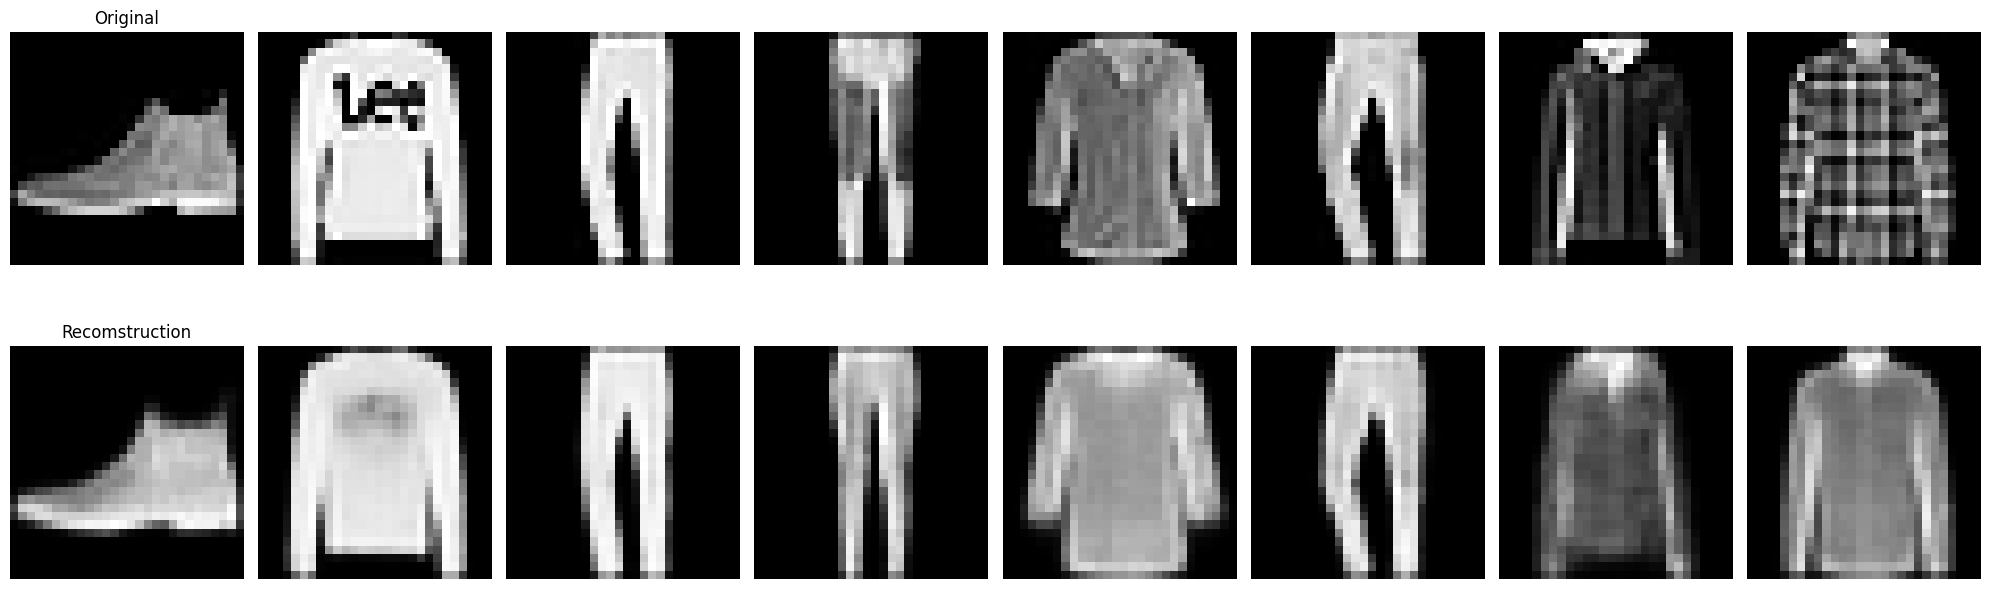

In [7]:

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(20, 7))
    
    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')
    
    plt.tight_layout()
    plt.show()


# 1. Récupérer un batch de données de test
batch_images, batch_labels = next(iter(test_loader))

# 2. Sélectionner un échantillon (ex: les 8 premières images)
n_samples = 8
inputs = batch_images[:n_samples].to(device)
labels = batch_labels[:n_samples].to(device)

# 3. Obtenir les reconstructions
cvae.eval() # Mode évaluation (désactive BatchNorm)
with torch.no_grad():
    recons, _, _ = cvae(inputs, labels) #encodage et decodage des 8 images

# 4. Préparation pour l'affichage (CPU + Numpy)
# On passe de [N, 1, 28, 28] à [N, 28, 28] avec squeeze()
original_images = inputs.cpu().numpy().squeeze()
reconstructed_images = recons.cpu().numpy().squeeze()   

image_comparison(original_images, reconstructed_images, n_images=n_samples)



On observe un plutot bonne reconstruction des images même sans optimisation spécifiques des hyperparamètres.

#### B. Visualisation de l'espace latent, Partie à améliorer ou à mettre ailleurs

Nous affichons seulement les deux premieres dimensions de l'espace latent.

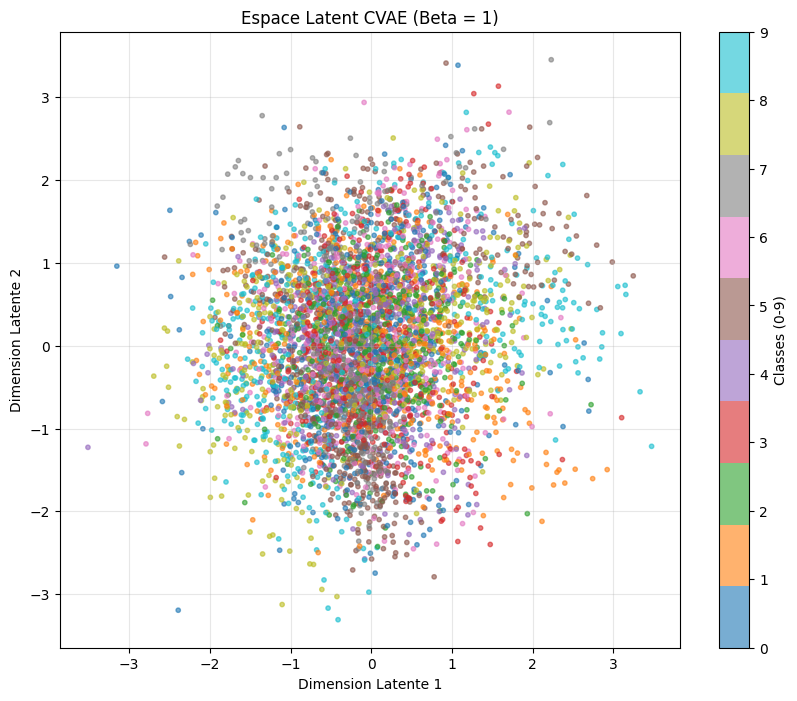

In [12]:

def plot_latent_space(model, beta):
    model.eval()
    with torch.no_grad():
        # On prend un grand lot d'images de test pour bien voir les clusters
        test_loader_viz = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5000, shuffle=False)
        data, labels = next(iter(test_loader_viz))
        data, labels = data.to(device), labels.to(device)
        
        # 1. Créer le vecteur One-Hot 'c' manuellement car model.encode() en a besoin
        c = torch.zeros(data.size(0), 10).to(device)
        c.scatter_(1, labels.view(-1, 1), 1)
        
        # 2. Encoder avec l'image ET la condition
        mu, logvar = model.encode(data, c)
        
        # 3. Récupérer les coordonnées (on utilise mu, la moyenne)
        z = mu.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        # 4. Affichage
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels_np, cmap='tab10', alpha=0.6, s=10)
        plt.colorbar(scatter, ticks=range(10), label='Classes (0-9)')
        plt.title(f'Espace Latent CVAE (Beta = {beta})')
        plt.xlabel('Dimension Latente 1')
        plt.ylabel('Dimension Latente 2')
        plt.grid(True, alpha=0.3)
        plt.show() #

plot_latent_space(cvae,beta)

Tous les points sont mélangés et c'est normal pour un cvae car on lui donne les étiquettes donc les vetements sont regroupés par style de dessin et non par classe. De plus, notre espace latent a 10 dimensions donc on observe ici qu'une petite partie de ce dernier.

# Génération de 5 nouveaux échantillons (Question 3)

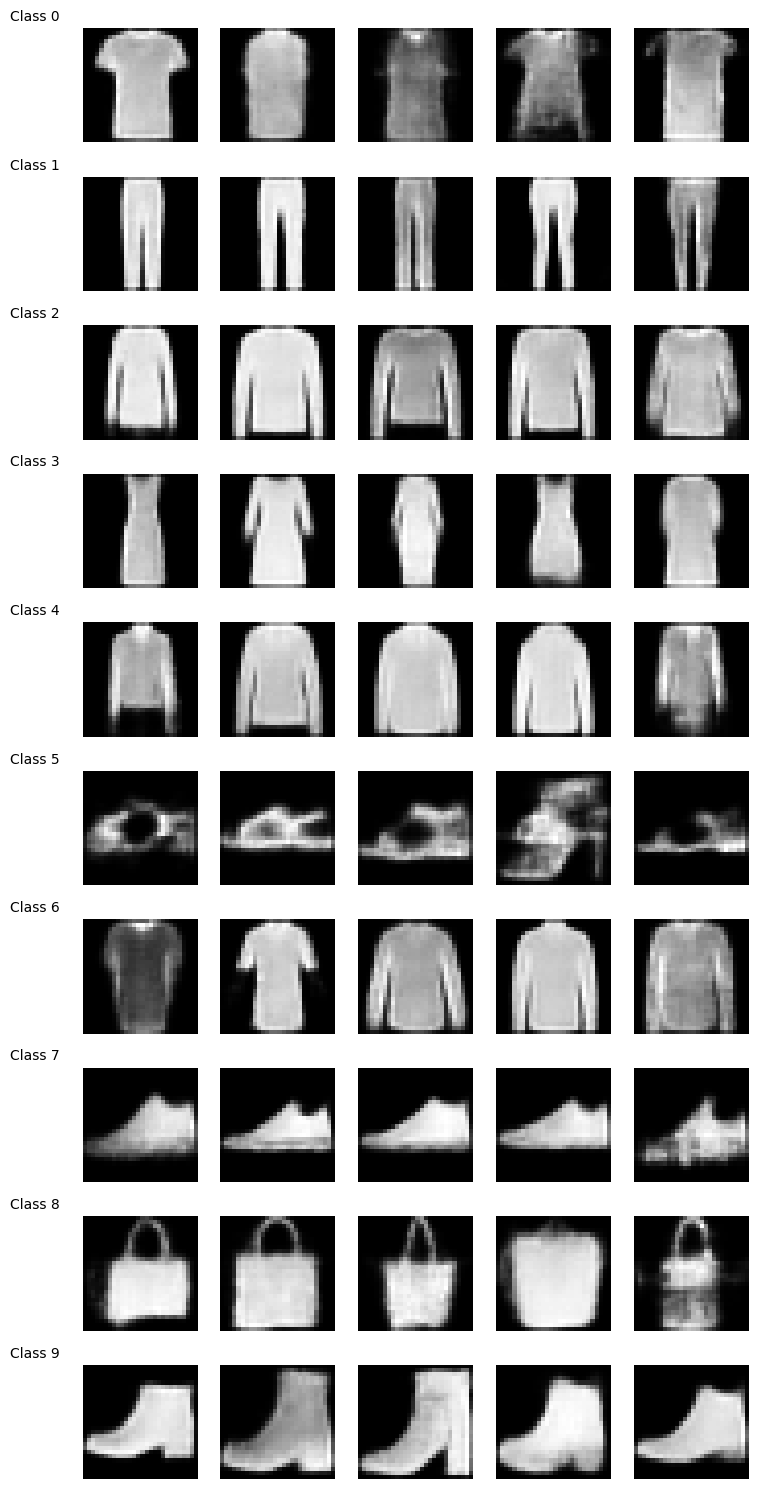

In [8]:
def generate_sample_per_class(num_samples=5):
    cvae.eval()
    num_classes = 10
    
    # On prépare une grille de plots : 10 lignes (classes), 5 colonnes (samples)
    fig, ax = plt.subplots(num_classes, num_samples, figsize=(num_samples * 1.5, num_classes * 1.5))
    
    with torch.no_grad():
        for class_idx in range(num_classes):
            # 1. Sample random latent vectors (z)
            # On génère 'num_samples' vecteurs de bruit
            z = torch.randn(num_samples, cvae.latent_dim).to(device) # z, le bruit, est aléatoire 
            
            # 2. Prepare the Condition (c)
            # On crée les labels pour la classe actuelle (ex: [0, 0, 0, 0, 0] pour la première boucle)
            labels = torch.tensor([class_idx] * num_samples).view(-1, 1).to(device) # on choisit la classe ( quel vetement on veut générer)
            
            # On convertit en One-Hot (nécessaire pour le décodeur du CVAE)
            c = torch.zeros(num_samples, num_classes).to(device)
            c.scatter_(1, labels, 1)
            
            # 3. Decode the latent vectors with the condition
            samples = cvae.decode(z, c)
            
            # Reshape pour l'affichage
            samples = samples.cpu().view(num_samples, 28, 28)

            # 4. Affichage dans la grille
            for i in range(num_samples):
                ax[class_idx, i].imshow(samples[i], cmap='gray')
                ax[class_idx, i].axis('off')
                
                # Ajout du titre seulement sur la première colonne
                if i == 0:
                    ax[class_idx, i].set_title(f"Class {class_idx}", fontsize=10, x=-0.2, ha='right')

    plt.tight_layout()
    plt.show()

# Lancer la génération
generate_sample_per_class(num_samples=5)

### Optimisation des hyperparamètres 

Nous cherchons à optimiser le learning rate, la taille de batch, beta de la fonction de perte.

Pour commencer, on crée un jeu de validation afin de tester nos hyperparamètres.

In [9]:
# Split test data into validation and test sets, comme dans le tp, attention ne pas run deux fois

val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

On utilise la classe CVAE défnie au début du projet.

### Point théorique : quel ordre pour l'optimisation des hyperparametres  ?

Pour l'optimisation, Il n'existe pas de règle absolue, mais la pratique standard en deep learning suit généralement cet ordre de priorité :

1. Définir une architecture de base (Baseline)

Avant d'optimiser, vous devez avoir une architecture cohérente avec la complexité de votre problème.

    Capacité du modèle : Si votre architecture est trop simple (ex: hidden_dim trop petit), le modèle subira un sous-apprentissage (underfitting), peu importe la qualité du learning rate.

    Objectif : Atteindre un niveau de performance minimal où le modèle commence à apprendre (la perte diminue).

2. Optimiser les hyperparamètres critiques (Learning Rate / Batch Size)

C'est l'étape la plus cruciale après avoir fixé l'architecture de base.

    Le Learning Rate (LR) : C'est l'hyperparamètre le plus important. Un mauvais LR empêchera n'importe quelle architecture de converger.

    Le Batch Size : Il influence la stabilité du gradient et la vitesse d'entraînement.

    Méthode : Utilisez un "Learning Rate Finder" ou une recherche aléatoire (Random Search) sur une échelle logarithmique.

3. Ajuster l'architecture (Fine-tuning structurel)

Une fois que vous avez un learning rate stable, vous pouvez affiner la structure :

    Ajouter ou retirer des couches.

    Modifier la dimension du width ou du hidden_dim.

    Ajouter de la régularisation (Dropout, Batch Normalization) si vous observez du sur-apprentissage (overfitting).

4. Itérer

Le processus est cyclique. Si vous changez radicalement l'architecture (ex: doubler le nombre de couches), vous devrez souvent réajuster légèrement le learning rate.
Résumé de la stratégie recommandée

    Architecture : Concevez une structure "raisonnable" (comme celle de votre code).

    Learning Rate : Trouvez la valeur optimale pour cette structure.

    Architecture : Testez des variations de profondeur/largeur pour améliorer les résultats.

    Hyperparamètres : Affinez le reste (poids, batch size, optimiseur).

Conseil technique : Pour un Autoencoder, commencez toujours par vérifier si le modèle peut "overfitter" (mémoriser parfaitement) un très petit échantillon de données (5-10 exemples). Si l'architecture et le learning rate ne permettent pas cela, le problème est structurel ou lié au LR.

In [11]:
# Code pour optimiser les hyperparametres : batch, dim latente, learning rate et beta

import itertools

def hyperparameter_search(train_dataset, val_dataset, device):
    # 1. Définition de la grille de recherche
    param_grid = {
        'latent_dim': [10, 20],
        'beta': [1.0, 5.0],
        'lr': [1e-3, 5e-4],
        'batch_size': [128, 256, 512]
    }
    
    # Génère toutes les combinaisons possibles
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    results = []
    epochs_test = 10 
    
    print(f"Total de combinaisons à tester : {len(combinations)}")
    
    for i, config in enumerate(combinations):
        print(f"\n--- Test {i+1}/{len(combinations)} : {config} ---")
        
        # DataLoader d'entraînement
        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset, 
            batch_size=config['batch_size'], 
            shuffle=True
        )
        
        # DataLoader de validation
        val_loader = torch.utils.data.DataLoader(
            dataset=val_dataset, 
            batch_size=config['batch_size'], 
            shuffle=False
        )
        
        # Initialisation du modèle et de l'optimiseur
        model = ConvCVAE(latent_dim=config['latent_dim'], num_classes=10).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
        
        # Entraînement (sur le train_dataset)
        train_cvae_model(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            epochs=epochs_test,
            beta=config['beta'],
            device=device
        )
        
        # --- Évaluation sur le val_dataset ---
        model.eval()
        val_bce_total = 0
        val_kld_total = 0
        
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                recon, mu, logvar = model(data, labels)
                _, bce, kld = loss_function(recon, data, mu, logvar, config['beta'])
                val_bce_total += bce.item()
                val_kld_total += kld.item()
        
        # Calcul des moyennes par image pour le jeu de validation
        avg_val_bce = val_bce_total / len(val_dataset)
        avg_val_kld = val_kld_total / len(val_dataset)
        
        # Stockage des résultats de validation
        config_results = {
            **config,
            'val_bce': avg_val_bce,
            'val_kld': avg_val_kld,
            'val_total': avg_val_bce + (config['beta'] * avg_val_kld)
        }
        results.append(config_results)
        print(f"Validation Result -> Total Loss: {config_results['val_total']:.2f}, BCE: {avg_val_bce:.2f}, KLD: {avg_val_kld:.2f}")

    return results

# Exécution avec les deux datasets distincts
all_results = hyperparameter_search(train_dataset, val_dataset, device)


Total de combinaisons à tester : 24

--- Test 1/24 : {'latent_dim': 10, 'beta': 1.0, 'lr': 0.001, 'batch_size': 128} ---
Début de l'entraînement : 10 epochs, Beta=1.0
--------------------------------------------------
Epoch [1/10] | Loss: 264.61 | BCE: 252.76 | KLD: 11.85
Epoch [2/10] | Loss: 243.81 | BCE: 231.58 | KLD: 12.23
Epoch [3/10] | Loss: 240.94 | BCE: 228.77 | KLD: 12.17
Epoch [4/10] | Loss: 239.38 | BCE: 227.21 | KLD: 12.17
Epoch [5/10] | Loss: 238.31 | BCE: 226.11 | KLD: 12.20
Epoch [6/10] | Loss: 237.60 | BCE: 225.39 | KLD: 12.21
Epoch [7/10] | Loss: 236.96 | BCE: 224.75 | KLD: 12.21
Epoch [8/10] | Loss: 236.49 | BCE: 224.26 | KLD: 12.23
Epoch [9/10] | Loss: 236.02 | BCE: 223.78 | KLD: 12.24
Epoch [10/10] | Loss: 235.69 | BCE: 223.44 | KLD: 12.25
--------------------------------------------------
Entraînement terminé.
Validation Result -> Total Loss: 237.14, BCE: 224.81, KLD: 12.33

--- Test 2/24 : {'latent_dim': 10, 'beta': 1.0, 'lr': 0.001, 'batch_size': 256} ---
Début de

In [ ]:
# Tri des résultats par la loss totale (ordre croissant car on minimise la perte)
sorted_results = sorted(all_results, key=lambda x: x['val_total'])

# Affichage du Top 3
print("\n--- TOP 3 DES MEILLEURES CONFIGURATIONS ---")
for i, res in enumerate(sorted_results[:3]):
    print(f"Rang {i+1} : Loss Totale = {res['val_total']:.4f}")
    print(f"  Configuration : latent_dim={res['latent_dim']}, beta={res['beta']}, lr={res['lr']}, batch_size={res['batch_size']}")
    print(f"  Détails : BCE={res['val_bce']:.4f}, KLD={res['val_kld']:.4f}")
    print("-" * 30)


--- TOP 3 DES MEILLEURES CONFIGURATIONS ---
Rang 1 : Loss Totale = 237.1388
  Configuration : latent_dim=10, beta=1.0, lr=0.001, batch_size=128
  Détails : BCE=224.8126, KLD=12.3262
------------------------------
Rang 2 : Loss Totale = 237.5676
  Configuration : latent_dim=10, beta=1.0, lr=0.0005, batch_size=128
  Détails : BCE=224.8002, KLD=12.7673
------------------------------
Rang 3 : Loss Totale = 237.7500
  Configuration : latent_dim=20, beta=1.0, lr=0.001, batch_size=128
  Détails : BCE=224.3062, KLD=13.4438
------------------------------


Après optimisation, nous gardons dim_lat=10, beta=1, lr=0.001, batch_size=128 qui sont les hyperparamètres qui minimisent le plus la perte. Nous allons maintenant chercher à optimiser l'architecture de notre CVAE.

### Optimisation de l'architecture

In [22]:


class SmallConvCVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10): 
        super(SmallConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # --- ENCODER PLUS PETIT ---
        # On divise par 2 le nombre de filtres : (16, 32, 64) au lieu de (32, 64, 128)
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 16, kernel_size=4, stride=2, padding=1), # Output: (16, 14, 14)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), # Output: (32, 7, 7)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # Transition vers l'espace latent avec la dimension réduite (64 * 4 * 4)
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

        # --- DECODER PLUS PETIT ---
        self.fc_decode = nn.Linear(latent_dim + num_classes, 64 * 4 * 4) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), # Output: (32, 7, 7)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # Output: (16, 14, 14)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1), # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, c): 
        # Étirement du label pour la concaténation spatiale
        c_expanded = c.view(-1, self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        inputs = torch.cat([x, c_expanded], 1)
        
        x = self.encoder(inputs)
        x = x.view(-1, 64 * 4 * 4) # Mise à jour pour 64 filtres
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        inputs = torch.cat([z, c], 1) 
        x = self.fc_decode(inputs)
        x = x.view(-1, 64, 4, 4) # Mise à jour pour 64 filtres
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        # 1. Création du One-Hot Vector (Logique identique au modèle normal)
        c = torch.zeros(x.size(0), self.num_classes).to(x.device)
        c.scatter_(1, labels.view(-1, 1), 1)
        
        # 2. Encodage
        mu, logvar = self.encode(x, c)
        
        # 3. Sampling
        z = self.sample(mu, logvar)
        
        # 4. Décodage
        recon_x = self.decode(z, c)
        
        return recon_x, mu, logvar

#### Comparaison des deux architectures


--- Évaluation architecture : Normal ---
Epoch 1 | Val Loss: 247.3257
Epoch 2 | Val Loss: 243.3290
Epoch 3 | Val Loss: 241.3102
Epoch 4 | Val Loss: 240.3935
Epoch 5 | Val Loss: 239.8887
Epoch 6 | Val Loss: 238.8072
Epoch 7 | Val Loss: 238.5842
Epoch 8 | Val Loss: 238.1973
Epoch 9 | Val Loss: 237.8311
Epoch 10 | Val Loss: 237.4104
Epoch 11 | Val Loss: 236.8397
Epoch 12 | Val Loss: 236.8096
Epoch 13 | Val Loss: 236.5465
Epoch 14 | Val Loss: 236.5521
Epoch 15 | Val Loss: 236.3577
Epoch 16 | Val Loss: 236.2187
Epoch 17 | Val Loss: 236.2784
Epoch 18 | Val Loss: 235.8271
Epoch 19 | Val Loss: 235.9280
Epoch 20 | Val Loss: 235.8428

--- Évaluation architecture : Petit ---
Epoch 1 | Val Loss: 249.5684
Epoch 2 | Val Loss: 246.4729
Epoch 3 | Val Loss: 243.2643
Epoch 4 | Val Loss: 242.2081
Epoch 5 | Val Loss: 241.4524
Epoch 6 | Val Loss: 240.6108
Epoch 7 | Val Loss: 240.3212
Epoch 8 | Val Loss: 239.9844
Epoch 9 | Val Loss: 239.3018
Epoch 10 | Val Loss: 238.9407
Epoch 11 | Val Loss: 238.8148
Epoch

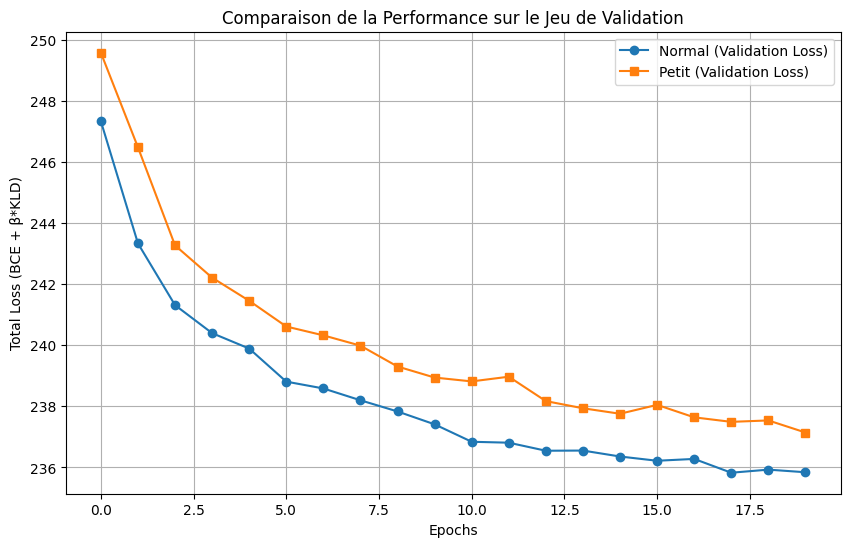

In [25]:
# --- Hyperparamètres optimaux ---
best_config = {
    'latent_dim': 10,
    'beta': 1.0,
    'lr': 0.001,
    'batch_size': 128
}

# --- DataLoaders ---
train_loader_comp = torch.utils.data.DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
val_loader_comp = torch.utils.data.DataLoader(val_dataset, batch_size=best_config['batch_size'], shuffle=False)

# --- Initialisation ---
models = {
    'Normal': ConvCVAE(latent_dim=best_config['latent_dim'], num_classes=10).to(device),
    'Petit': SmallConvCVAE(latent_dim=best_config['latent_dim'], num_classes=10).to(device)
}

# Dictionnaires pour stocker les scores de validation
val_history = {'Normal': [], 'Petit': []}

for name, model in models.items():
    print(f"\n--- Évaluation architecture : {name} ---")
    optimizer = optim.Adam(model.parameters(), lr=best_config['lr'])
    
    for epoch in range(1, 21):
        # Phase d'entraînement
        model.train()
        for data, labels in train_loader_comp:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, beta=best_config['beta'])
            loss.backward()
            optimizer.step()
        
        # Phase de Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for data, labels in val_loader_comp:
                data, labels = data.to(device), labels.to(device)
                recon, mu, logvar = model(data, labels)
                # Calcul de la loss sur le set de validation
                loss, _, _ = loss_function(recon, data, mu, logvar, beta=best_config['beta'])
                epoch_val_loss += loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_dataset)
        val_history[name].append(avg_val_loss)
        print(f"Epoch {epoch} | Val Loss: {avg_val_loss:.4f}")

# --- Visualisation des résultats de validation ---
plt.figure(figsize=(10, 6))
plt.plot(val_history['Normal'], label="Normal (Validation Loss)", marker='o')
plt.plot(val_history['Petit'], label="Petit (Validation Loss)", marker='s')
plt.title("Comparaison de la Performance sur le Jeu de Validation")
plt.xlabel("Epochs")
plt.ylabel("Total Loss (BCE + β*KLD)")
plt.legend()
plt.grid(True)
plt.show()

La strcuture normale du CVAE est plus efficiente.

### Check sur-apprentissage

Début de l'analyse du surapprentissage...
Epoch 1/20 | Train Loss: 265.4004 | Val Loss: 247.6400
Epoch 2/20 | Train Loss: 243.8354 | Val Loss: 243.9872
Epoch 3/20 | Train Loss: 240.9557 | Val Loss: 242.0709
Epoch 4/20 | Train Loss: 239.4584 | Val Loss: 241.1427
Epoch 5/20 | Train Loss: 238.4655 | Val Loss: 239.3681
Epoch 6/20 | Train Loss: 237.7752 | Val Loss: 238.8238
Epoch 7/20 | Train Loss: 237.1625 | Val Loss: 238.2975
Epoch 8/20 | Train Loss: 236.8143 | Val Loss: 238.5158
Epoch 9/20 | Train Loss: 236.3688 | Val Loss: 237.9820
Epoch 10/20 | Train Loss: 235.9718 | Val Loss: 237.8077
Epoch 11/20 | Train Loss: 235.7086 | Val Loss: 237.2785
Epoch 12/20 | Train Loss: 235.5079 | Val Loss: 236.8281
Epoch 13/20 | Train Loss: 235.2963 | Val Loss: 237.2220
Epoch 14/20 | Train Loss: 235.0927 | Val Loss: 236.7139
Epoch 15/20 | Train Loss: 234.8950 | Val Loss: 236.2505
Epoch 16/20 | Train Loss: 234.7287 | Val Loss: 236.2452
Epoch 17/20 | Train Loss: 234.5774 | Val Loss: 236.3936
Epoch 18/20 | T

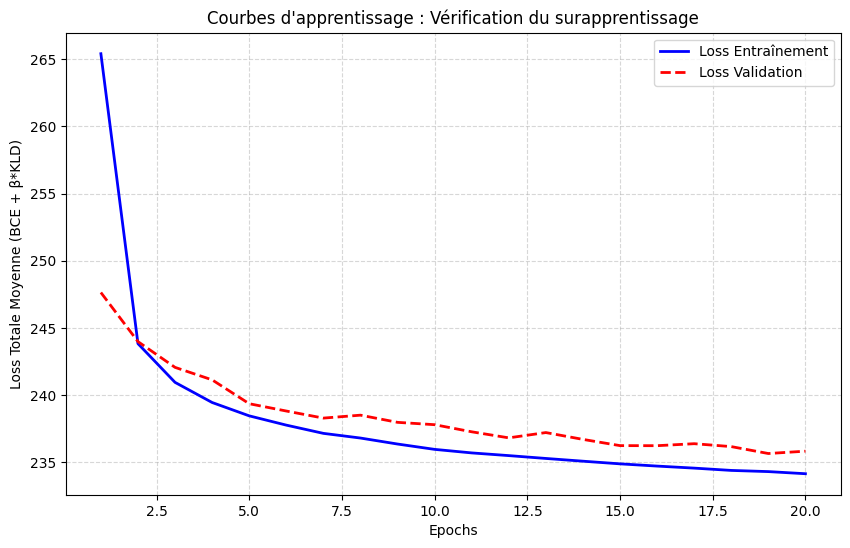

In [24]:
# Configuration
best_config = {
    'latent_dim': 10,
    'beta': 1.0,
    'lr': 0.001,
    'batch_size': 128
}
epochs = 20

# Préparation des DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_config['batch_size'], shuffle=False)

# Initialisation du modèle normal
model = ConvCVAE(latent_dim=best_config['latent_dim'], num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_config['lr'])

train_losses = []
val_losses = []

print("Début de l'analyse du surapprentissage...")

for epoch in range(1, epochs + 1):
    # --- Phase d'Entraînement ---
    model.train()
    total_train_loss = 0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        
        recon, mu, logvar = model(data, labels)
        loss, _, _ = loss_function(recon, data, mu, logvar, beta=best_config['beta'])
        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    
    # --- Phase de Validation ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, beta=best_config['beta'])
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# --- Visualisation des courbes d'apprentissage ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Loss Entraînement', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Loss Validation', color='red', linestyle='--', linewidth=2)
plt.title("Courbes d'apprentissage : Vérification du surapprentissage")
plt.xlabel("Epochs")
plt.ylabel("Loss Totale Moyenne (BCE + β*KLD)")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

Pas de surapprentisagge visible.

## Test sur le jeu de test

--- RÉSULTATS FINAUX (TEST SET) ---
Total Loss : 237.7013
BCE (Reconstruction) : 225.4285
KLD (Régularisation) : 12.2728


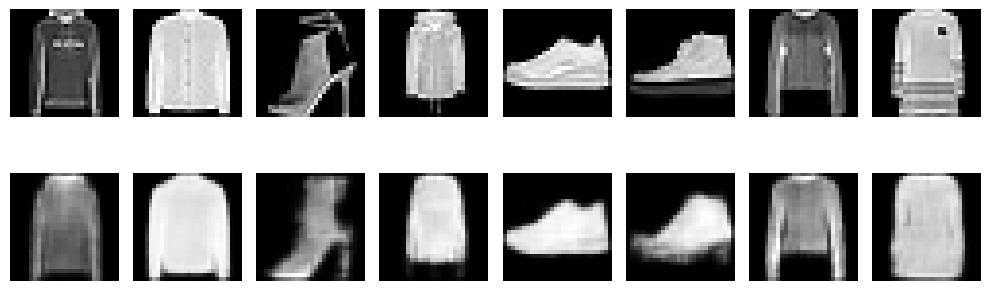

In [27]:
def final_test_evaluation(model, test_loader, device, beta):
    model.eval()
    test_bce = 0
    test_kld = 0
    test_total = 0
    
    # Pour la visualisation
    originals = []
    reconstructions = []
    
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            
            # Forward pass
            recon, mu, logvar = model(data, labels)
            
            # Calcul de la perte
            loss, bce, kld = loss_function(recon, data, mu, logvar, beta)
            
            test_total += loss.item()
            test_bce += bce.item()
            test_kld += kld.item()
            
            # Garder quelques exemples pour l'affichage
            if i == 0:
                originals = data.cpu()
                reconstructions = recon.cpu()

    # Moyennes
    n_test = len(test_loader.dataset)
    print(f"--- RÉSULTATS FINAUX (TEST SET) ---")
    print(f"Total Loss : {test_total / n_test:.4f}")
    print(f"BCE (Reconstruction) : {test_bce / n_test:.4f}")
    print(f"KLD (Régularisation) : {test_kld / n_test:.4f}")
    
    return originals, reconstructions

# Exécution
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
orig, rec = final_test_evaluation(model, test_loader, device, best_config['beta'])

# Visualisation
plt.figure(figsize=(10, 4))
for i in range(8):
    # Originaux
    plt.subplot(2, 8, i + 1)
    plt.imshow(orig[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Original")
    
    # Reconstructions
    plt.subplot(2, 8, i + 9)
    plt.imshow(rec[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Reconstruit")
plt.tight_layout()
plt.show()

partie fonction de perte à optimiser - partie a reprendre

In [26]:
 # On reprend ton modèle standard
final_model = ConvCVAE(latent_dim=2).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=1e-3)

history_bce = []
history_kld = []
epochs_loss = 10 # Suffisant pour voir la dynamique

print("--- Analyse des composantes de la Loss ---")

for epoch in range(epochs_loss):
    final_model.train()
    epoch_bce = 0
    epoch_kld = 0
    
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = final_model(data, labels)
        
        # On récupère les composants séparés
        loss, bce, kld = loss_function(recon, data, mu, logvar, beta=1)
        
        loss.backward()
        optimizer.step()
        
        epoch_bce += bce.item()
        epoch_kld += kld.item()
        
    history_bce.append(epoch_bce / len(train_loader))
    history_kld.append(epoch_kld / len(train_loader))

# Plot avec deux échelles (car BCE est très grand et KLD très petit)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Reconstruction Loss (BCE)', color=color)
ax1.plot(history_bce, color=color, label='BCE (Qualité Image)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instancier un deuxième axe y
color = 'tab:red'
ax2.set_ylabel('KL Divergence (KLD)', color=color)
ax2.plot(history_kld, color=color, linestyle='--', label='KLD (Régularisation)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Dynamique d'apprentissage : BCE vs KLD")
fig.tight_layout()
plt.show()##

--- Analyse des composantes de la Loss ---


KeyboardInterrupt: 